# **Action classification task based on Internet Firewall logs**


In [1]:
!wget https://archive.ics.uci.edu/ml/machine-learning-databases/00542/log2.csv

--2021-11-12 10:58:18--  https://archive.ics.uci.edu/ml/machine-learning-databases/00542/log2.csv
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2876998 (2.7M) [application/x-httpd-php]
Saving to: ‘log2.csv’

log2.csv            100%[===================>]   2.74M  5.41MB/s    in 0.5s    

2021-11-12 10:58:19 (5.41 MB/s) - ‘log2.csv’ saved [2876998/2876998]



In [2]:
!wget https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/Classification_evaluation_security_dataset_L2/log2.csv

--2021-11-12 10:58:25--  https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/Classification_evaluation_security_dataset_L2/log2.csv
Resolving cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud (cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud)... 198.23.119.245
Connecting to cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud (cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud)|198.23.119.245|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2811465 (2.7M) [text/csv]
Saving to: ‘log2.csv.1’

log2.csv.1          100%[===================>]   2.68M  7.21MB/s    in 0.4s    

2021-11-12 10:58:26 (7.21 MB/s) - ‘log2.csv.1’ saved [2811465/2811465]



In [3]:
!pip install scikit-plot
!pip install imblearn

In [4]:
import pandas as pd
import os
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import scikitplot as sk
from collections import Counter
from sklearn.model_selection import StratifiedKFold
from sklearn import *
import time

%matplotlib inline
sns.set(style = "darkgrid")
plt.rcParams['figure.figsize'] = (15, 5)
plt.style.use('ggplot')
seed = 42

import warnings
warnings.filterwarnings(action = "ignore", category = FutureWarning)

In [5]:
pd.set_option("precision", 3)
pd.options.display.float_format = '{:.3f}'.format

In [6]:
df = pd.read_csv('log2.csv', header = 0)
df.head(5)

,Source Port,Destination Port,NAT Source Port,NAT Destination Port,Action,Bytes,Bytes Sent,Bytes Received,Packets,Elapsed Time (sec),pkts_sent,pkts_received
0,57222,53,54587,53,allow,177,94,83,2,30,1,1
1,56258,3389,56258,3389,allow,4768,1600,3168,19,17,10,9
2,6881,50321,43265,50321,allow,238,118,120,2,1199,1,1
3,50553,3389,50553,3389,allow,3327,1438,1889,15,17,8,7
4,50002,443,45848,443,allow,25358,6778,18580,31,16,13,18


In [7]:
df.shape

(65532, 12)

In [8]:
df.columns

Index(['Source Port', 'Destination Port', 'NAT Source Port',
       'NAT Destination Port', 'Action', 'Bytes', 'Bytes Sent',
       'Bytes Received', 'Packets', 'Elapsed Time (sec)', 'pkts_sent',
       'pkts_received'],
      dtype='object')

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 65532 entries, 0 to 65531
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   Source Port           65532 non-null  int64 
 1   Destination Port      65532 non-null  int64 
 2   NAT Source Port       65532 non-null  int64 
 3   NAT Destination Port  65532 non-null  int64 
 4   Action                65532 non-null  object
 5   Bytes                 65532 non-null  int64 
 6   Bytes Sent            65532 non-null  int64 
 7   Bytes Received        65532 non-null  int64 
 8   Packets               65532 non-null  int64 
 9   Elapsed Time (sec)    65532 non-null  int64 
 10  pkts_sent             65532 non-null  int64 
 11  pkts_received         65532 non-null  int64 
dtypes: int64(11), object(1)
memory usage: 6.0+ MB


In [10]:
df.describe().T


,count,mean,std,min,25%,50%,75%,max
Source Port,65532.000,49391.969,15255.713,0.000,49183.000,53776.500,58638.000,65534.000
Destination Port,65532.000,10577.386,18466.027,0.000,80.000,445.000,15000.000,65535.000
NAT Source Port,65532.000,19282.973,21970.690,0.000,0.000,8820.500,38366.250,65535.000
NAT Destination Port,65532.000,2671.050,9739.162,0.000,0.000,53.000,443.000,65535.000
Bytes,65532.000,97123.950,5618438.909,60.000,66.000,168.000,752.250,1269359015.000
Bytes Sent,65532.000,22385.797,3828138.650,60.000,66.000,90.000,210.000,948477220.000
Bytes Received,65532.000,74738.153,2463207.712,0.000,0.000,79.000,449.000,320881795.000
Packets,65532.000,102.866,5133.002,1.000,1.000,2.000,6.000,1036116.000
Elapsed Time (sec),65532.000,65.834,302.462,0.000,0.000,15.000,30.000,10824.000
pkts_sent,65532.000,41.400,3218.871,1.000,1.000,1.000,3.000,747520.000


In [11]:
[df[i].unique() for i in df if df[i].dtypes == "object"]

[array(['allow', 'drop', 'deny', 'reset-both'], dtype=object)]

In [12]:
df.columns = df.columns.str.lower().str.replace(" ","_")
df.head(7)

,source_port,destination_port,nat_source_port,nat_destination_port,action,bytes,bytes_sent,bytes_received,packets,elapsed_time_(sec),pkts_sent,pkts_received
0,57222,53,54587,53,allow,177,94,83,2,30,1,1
1,56258,3389,56258,3389,allow,4768,1600,3168,19,17,10,9
2,6881,50321,43265,50321,allow,238,118,120,2,1199,1,1
3,50553,3389,50553,3389,allow,3327,1438,1889,15,17,8,7
4,50002,443,45848,443,allow,25358,6778,18580,31,16,13,18
5,51465,443,39975,443,allow,3961,1595,2366,21,16,12,9
6,60513,47094,45469,47094,allow,320,140,180,6,7,3,3


In [13]:
Counter(df.action)

Counter({'allow': 37640, 'deny': 14987, 'drop': 12851, 'reset-both': 54})

In [14]:
from imblearn.over_sampling import SMOTE

lab = preprocessing.LabelEncoder()
df.action = lab.fit_transform(df.action)

data_out = df.drop("action", axis = 1)


quant_1 = data_out.quantile(0.25)
quant_3 = data_out.quantile(0.75)
diff = quant_3 - quant_1
data = df[~((df < (quant_1 - 1.5 * diff)) |(df > (quant_3 + 1.5 * diff))).any(axis = 1)]

In [15]:
data.shape, Counter(data.action)

((34531, 12), Counter({0: 16649, 1: 5020, 2: 12851, 3: 11}))

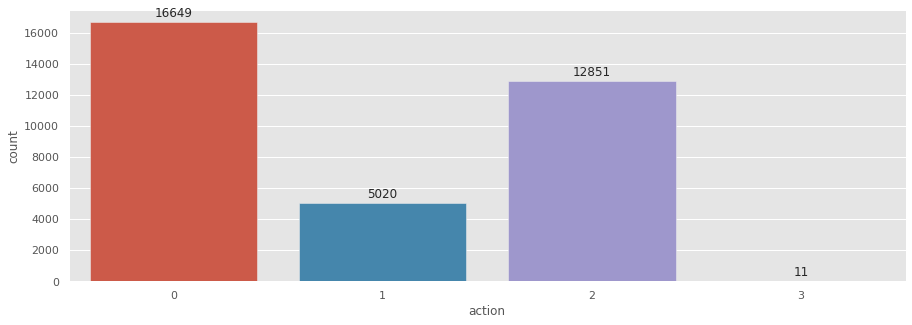

In [16]:
fig = sns.countplot(data.action)
for p in fig.patches:
    fig.annotate(format(p.get_height(), '.0f'), 
                   (p.get_x() + p.get_width() / 2., p.get_height()), 
                   ha = 'center', va = 'center', 
                   xytext = (0, 9), size = 12,
                   textcoords = 'offset points')

In [17]:
feature, target = data.drop("action", axis = 1).values, data["action"].values
sm = SMOTE(random_state = seed)
feature, target = sm.fit_resample(feature, target)

In [18]:
Counter(target)

Counter({0: 16649, 1: 16649, 2: 16649, 3: 16649})

In [19]:
xtrain, xtest, ytrain, ytest = model_selection.train_test_split(feature, target,
                                                                test_size = 0.3,
                                                                random_state = seed,
                                                                stratify = target,
                                                                shuffle = True)

In [20]:
xtrain.shape, xtest.shape, ytrain.shape, ytest.shape

((46617, 11), (19979, 11), (46617,), (19979,))

In [21]:
xtrain = preprocessing.StandardScaler().fit_transform(xtrain)
xtest = preprocessing.StandardScaler().fit_transform(xtest)

In [22]:
AUTOTUNE = os.cpu_count()
Classifiers = {
    "Linear_Regressor": linear_model.LogisticRegression(C = 10, solver = 'liblinear'), 
   
    "Random_Forest": ensemble.RandomForestClassifier(random_state = seed, n_jobs = AUTOTUNE), 
    "Ada_Boost": ensemble.AdaBoostClassifier(tree.DecisionTreeClassifier(random_state = seed),
                                             random_state = seed,
                                             learning_rate = 0.1),  
    
    "Ex_Tree_Classifier": ensemble.ExtraTreesClassifier(random_state = seed, n_jobs = AUTOTUNE),  
    
    "kNN": neighbors.KNeighborsClassifier(n_jobs = AUTOTUNE), 
    "Decision_Tree": tree.DecisionTreeClassifier(random_state = seed)  
}

Elapsed time: 429.57 sec



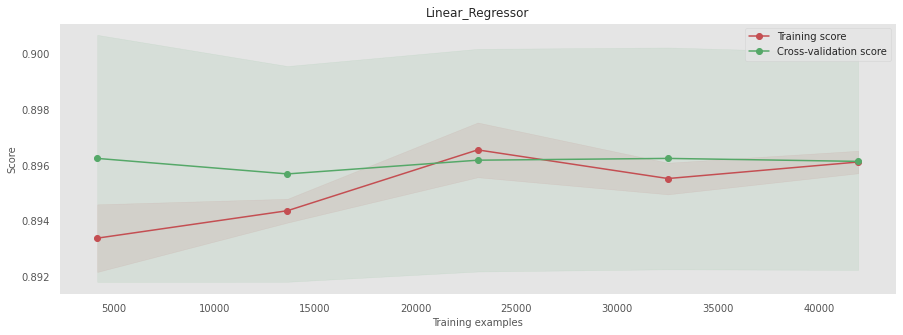

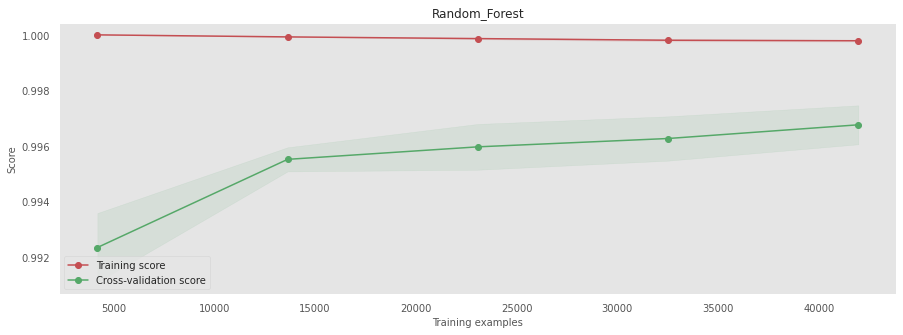

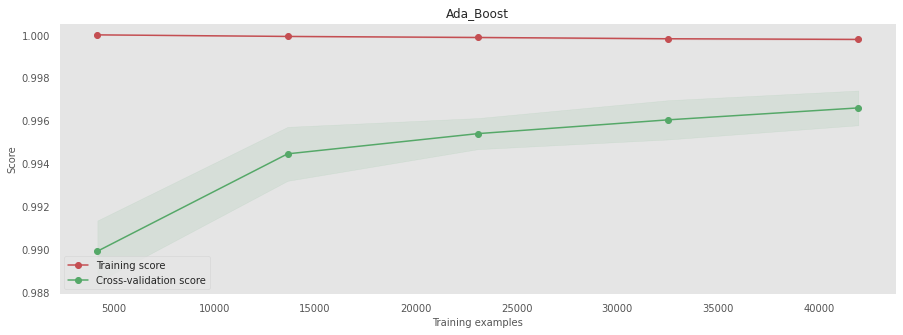

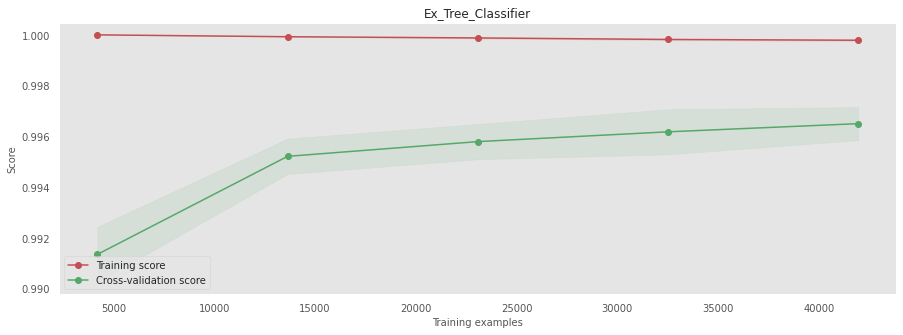

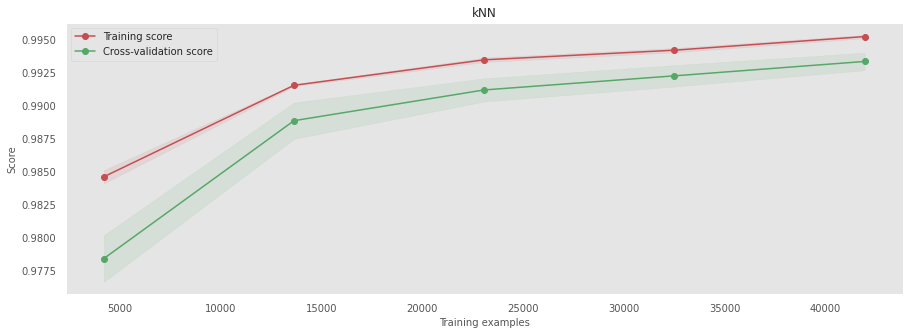

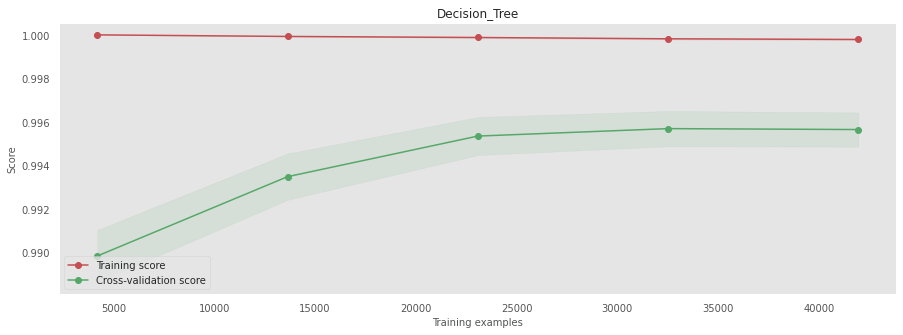

In [23]:
start_time = time.time()
kfold = StratifiedKFold(n_splits = 10)
for name, classifier in Classifiers.items():
    sk.estimators.plot_learning_curve(classifier, xtrain, ytrain,
                                      cv = kfold,
                                      title = name,
                                      random_state = seed,
                                      n_jobs = -1)
print("Elapsed time:", round(time.time() - start_time, 2), 'sec\n')

****    Estimations    ****
Test accuracy:  90.09%    Name: Linear_Regressor
Train accuracy:  89.61%
Log_loss:  0.2822
Correct   points:  17999
Incorrect points:  1980
****    Estimations    ****
Test accuracy:  74.67%    Name: Random_Forest
Train accuracy:  99.98%
Log_loss:  0.3297
Correct   points:  14919
Incorrect points:  5060
****    Estimations    ****
Test accuracy:  81.09%    Name: Ada_Boost
Train accuracy:  99.98%
Log_loss:  3.2288
Correct   points:  16200
Incorrect points:  3779
****    Estimations    ****
Test accuracy:  99.13%    Name: Ex_Tree_Classifier
Train accuracy:  99.98%
Log_loss:  0.1019
Correct   points:  19805
Incorrect points:  174
****    Estimations    ****
Test accuracy:  99.45%    Name: kNN
Train accuracy:  99.56%
Log_loss:  0.0946
Correct   points:  19869
Incorrect points:  110
****    Estimations    ****
Test accuracy:  73.76%    Name: Decision_Tree
Train accuracy:  99.98%
Log_loss:  9.0639
Correct   points:  14736
Incorrect points:  5243

Elapsed time: 31.

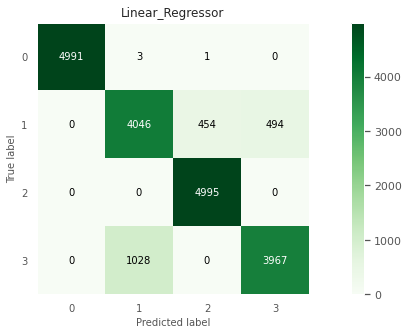

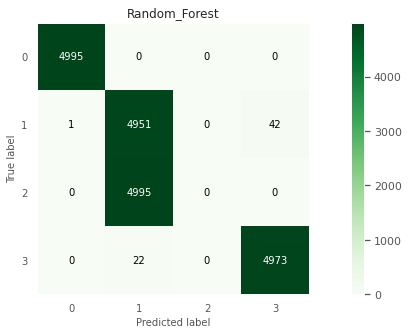

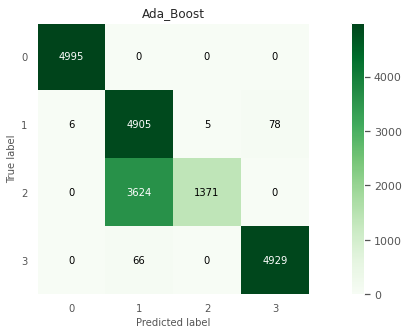

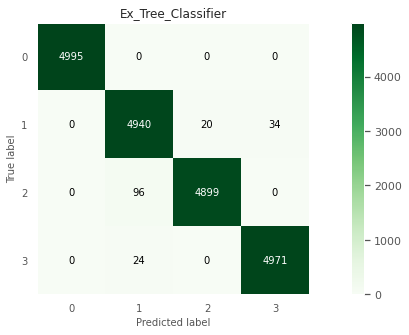

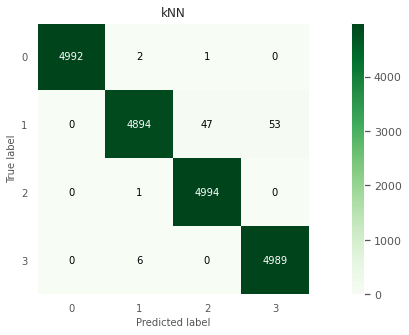

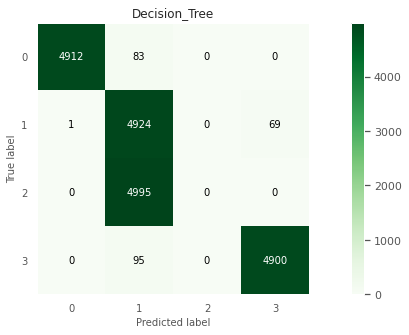

In [24]:
from sklearn.metrics import log_loss

start_time = time.time()
logging_cols=["Classifier", "Test accuracy", "Train accuracy", "Log_loss", "Correct_cases", "Incorrect_cases"]
logging = pd.DataFrame(columns = logging_cols)

for name_c , classif_c in Classifiers.items():
    classif_c.fit(xtrain, ytrain)
    predict = classif_c.predict(xtest)
    accuracy = classif_c.score(xtest, ytest)
    train_pred = classif_c.predict_proba(xtest)
    lg_ls = log_loss(ytest, train_pred)
    train_test_acc = classif_c.score(xtrain, ytrain)
    correct = (ytest == predict).sum()
    incorrect = (ytest != predict).sum()
    
    print("="*45)
    print('****    Estimations    ****')
    print(f"Test accuracy:  {accuracy*100:.2f}%    Name: {name_c}")
    print(f"Train accuracy:  {train_test_acc*100:.2f}%")
    print(f"Log_loss:  {lg_ls:.4f}")
    print(f"Correct   points:  {correct}")
    print(f"Incorrect points:  {incorrect}")
    sk.metrics.plot_confusion_matrix(ytest, predict, title = name_c, cmap = plt.cm.Greens)
    logging_entry = pd.DataFrame([[name_c, accuracy*100, train_test_acc*100, lg_ls, correct, incorrect]], columns = logging_cols)
    logging = logging.append(logging_entry)
print("\nElapsed time:", round(time.time() - start_time, 2), 'sec\n')

In [25]:
logging

,Classifier,Test accuracy,Train accuracy,Log_loss,Correct_cases,Incorrect_cases
0,Linear_Regressor,90.090,89.607,0.282,17999,1980
0,Random_Forest,74.673,99.976,0.330,14919,5060
0,Ada_Boost,81.085,99.976,3.229,16200,3779
0,Ex_Tree_Classifier,99.129,99.976,0.102,19805,174
0,kNN,99.449,99.558,0.095,19869,110
0,Decision_Tree,73.757,99.976,9.064,14736,5243


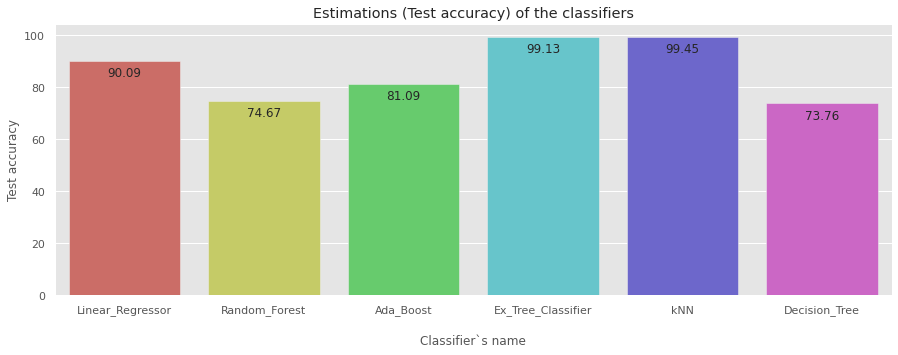

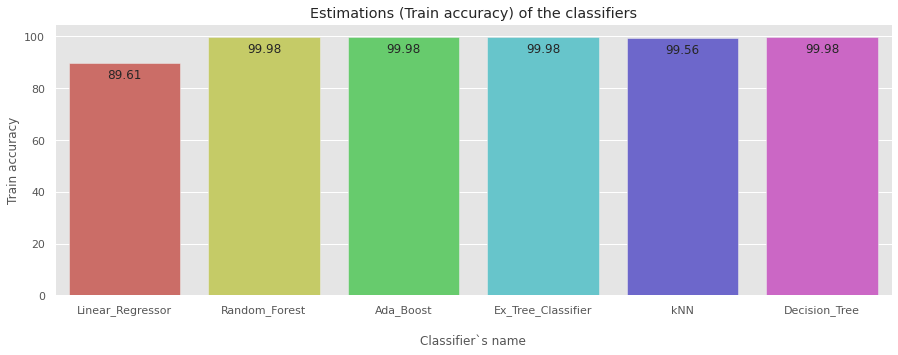

In [26]:
sns.set_color_codes("muted")
graph = sns.barplot(x = 'Classifier',
                    y = 'Test accuracy',
                    data = logging,          
                    palette = 'hls')

for p in graph.patches:
    graph.annotate(format(p.get_height(), '.2f'), 
                   (p.get_x() + p.get_width() / 2., p.get_height()), 
                   ha = 'center', va = 'center', 
                   xytext = (0, -12), size = 12,
                   textcoords = 'offset points')

plt.xlabel('\nClassifier`s name')
plt.title('Estimations (Test accuracy) of the classifiers')
plt.show()

sns.set_color_codes("muted")
graph = sns.barplot(x = 'Classifier',
                    y = 'Train accuracy',
                    data = logging,          
                    palette = 'hls')

for p in graph.patches:
    graph.annotate(format(p.get_height(), '.2f'), 
                   (p.get_x() + p.get_width() / 2., p.get_height()), 
                   ha = 'center', va = 'center', 
                   xytext = (0, -12), size = 12,
                   textcoords = 'offset points')

plt.xlabel('\nClassifier`s name')
plt.title('Estimations (Train accuracy) of the classifiers')
plt.show()

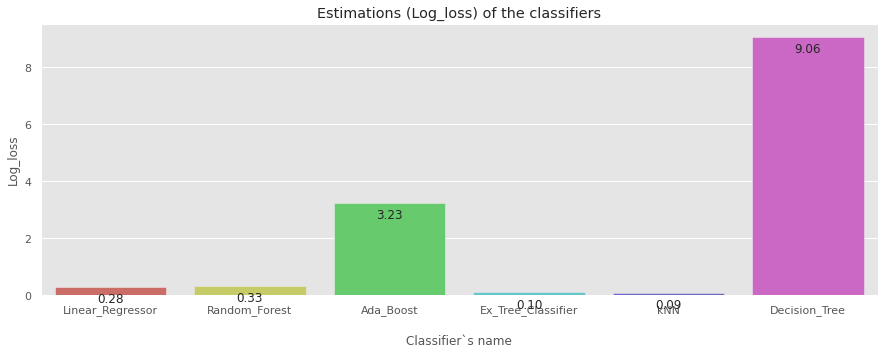

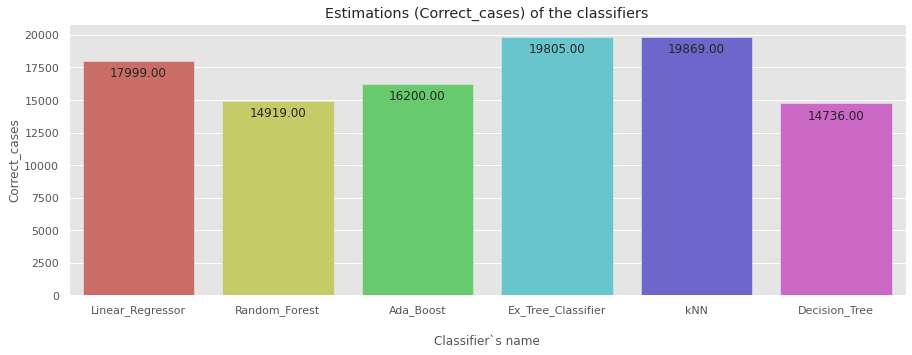

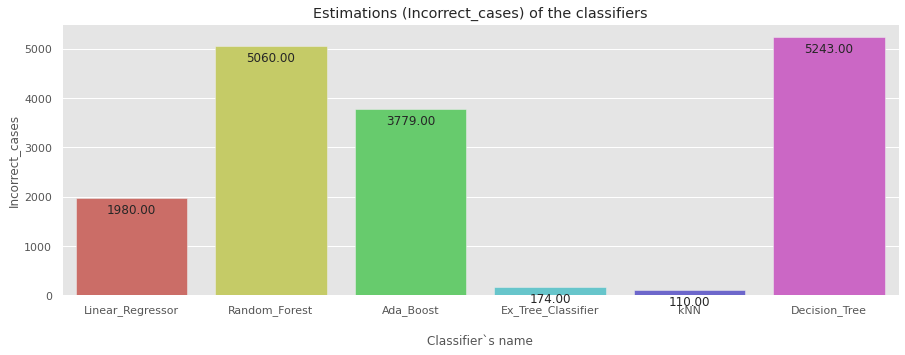

In [27]:
sns.set_color_codes("muted")
graph = sns.barplot(x = 'Classifier',
                    y = 'Log_loss',
                    data = logging,          
                    palette = 'hls')

for p in graph.patches:
    graph.annotate(format(p.get_height(), '.2f'), 
                   (p.get_x() + p.get_width() / 2., p.get_height()), 
                   ha = 'center', va = 'center', 
                   xytext = (0, -12), size = 12,
                   textcoords = 'offset points')

plt.xlabel('\nClassifier`s name')
plt.title('Estimations (Log_loss) of the classifiers')
plt.show()

graph = sns.barplot(x = 'Classifier',
                    y = 'Correct_cases',
                    data = logging,          
                    palette = 'hls')

for p in graph.patches:
    graph.annotate(format(p.get_height(), '.2f'), 
                   (p.get_x() + p.get_width() / 2., p.get_height()), 
                   ha = 'center', va = 'center', 
                   xytext = (0, -12), size = 12,
                   textcoords = 'offset points')

plt.xlabel('\nClassifier`s name')
plt.title('Estimations (Correct_cases) of the classifiers')
plt.show()

graph = sns.barplot(x = 'Classifier',
                    y = 'Incorrect_cases',
                    data = logging,          
                    palette = 'hls')

for p in graph.patches:
    graph.annotate(format(p.get_height(), '.2f'), 
                   (p.get_x() + p.get_width() / 2., p.get_height()), 
                   ha = 'center', va = 'center', 
                   xytext = (0, -12), size = 12,
                   textcoords = 'offset points')

plt.xlabel('\nClassifier`s name')
plt.title('Estimations (Incorrect_cases) of the classifiers')
plt.show()